In [22]:
# data organization libraries
import numpy as np
import pandas as pd
# viz
import matplotlib.pyplot as plt
import seaborn as sns
# modeling libraries
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [23]:
# get raw
raw = pd.read_csv('raw_df.csv')

raw.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_cat,temp_bins
0,1,2,8,5,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.00,0-5,>25
1,5,4,8,2,95.1,141.3,605.8,17.7,26.4,34,3.6,0.0,16.40,10-50,>25
2,6,5,8,3,92.1,111.2,654.1,9.6,16.6,47,0.9,0.0,2.29,0-5,15-20
3,6,3,8,4,91.6,138.1,621.7,6.3,18.9,41,3.1,0.0,10.34,10-50,15-20
4,4,5,8,0,90.2,99.6,631.2,6.3,21.4,33,3.1,0.0,0.00,0-5,20-25


In [24]:
temp_bins = raw['temp_bins'].value_counts()

temp_bins

15-20    884
20-25    840
0-15     572
>25      356
Name: temp_bins, dtype: int64

In [25]:
temp_twen = raw[raw['temp_bins'] == '20-25']

temp_twen.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_cat,temp_bins
4,4,5,8,0,90.2,99.6,631.2,6.3,21.4,33,3.1,0.0,0.00,0-5,20-25
5,9,9,8,5,94.8,227.0,706.7,12.0,25.0,36,4.0,0.0,0.00,0-5,20-25
6,4,4,8,2,96.1,181.1,671.2,14.3,20.7,69,4.9,0.4,0.00,0-5,20-25
7,2,4,8,2,94.8,108.3,647.1,17.0,20.1,40,4.0,0.0,0.00,0-5,20-25
8,2,5,8,5,93.9,135.7,586.7,15.1,23.5,36,5.4,0.0,10.02,10-50,20-25


In [26]:
area_fifty = raw[raw['area_cat'] == '10-50']

area_fifty.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_cat,temp_bins
1,5,4,8,2,95.1,141.3,605.8,17.7,26.4,34,3.6,0.0,16.40,10-50,>25
3,6,3,8,4,91.6,138.1,621.7,6.3,18.9,41,3.1,0.0,10.34,10-50,15-20
8,2,5,8,5,93.9,135.7,586.7,15.1,23.5,36,5.4,0.0,10.02,10-50,20-25
16,4,3,8,3,94.5,139.4,689.1,20.0,28.9,29,4.9,0.0,49.59,10-50,>25
26,7,4,8,0,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,10-50,20-25


In [28]:
# names = ['temp_bins', 'area_cat'], keys = ['>25', '0-5']
def filter_df(df, names, keys):
    
    if len(keys) == 2:
    
        ret = df[(df[names[0]] == keys[0]) & (df[names[1]] == keys[1])]
    
    else:
        
        ret = df[df[names[0]] == keys[0]]
        
    
    return ret


In [32]:
high_temp_low_area = filter_df(raw, ['temp_bins'], ['20-25'])

high_temp_low_area.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_cat,temp_bins
4,4,5,8,0,90.2,99.6,631.2,6.3,21.4,33,3.1,0.0,0.00,0-5,20-25
5,9,9,8,5,94.8,227.0,706.7,12.0,25.0,36,4.0,0.0,0.00,0-5,20-25
6,4,4,8,2,96.1,181.1,671.2,14.3,20.7,69,4.9,0.4,0.00,0-5,20-25
7,2,4,8,2,94.8,108.3,647.1,17.0,20.1,40,4.0,0.0,0.00,0-5,20-25
8,2,5,8,5,93.9,135.7,586.7,15.1,23.5,36,5.4,0.0,10.02,10-50,20-25


In [33]:
len(high_temp_low_area)

840

In [34]:
# bias_dics = [month_dic, temp_dic, area_dic], type:list

In [35]:
#temp_dic = {'15-20': .5, '20-25': .25, '0-15': .2, '>25': .05}

#for i in temp_dic: 
    #print(i, temp_dic[i]) 

In [36]:
def sk_test_train(df, target, features, test_ratio):
    X_df = df.iloc[:, features]
    
    X = X_df.to_numpy()
    
    y_df = df.iloc[:, target]
    
    y = y_df.to_numpy()
    
    y = y.flatten()
    
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=0)
    
    return X_train, X_test, y_train, y_test

In [41]:
def sample_dic(cat_dic, size):
    
    samp_dic = {}
    
    for i in cat_dic:
        
        samp_dic[i] = size * cat_dic[i]
    
    return samp_dic
    
    
    

In [54]:
def gen_sample(df, num, rand):
    
    return df.sample(n=num, random_state=rand)

In [55]:
def biased_sample(df, size, bias_dics):
    
    ret_df = pd.DataFrame()
    
    samp_dic = sample_dic(bias_dics[0], size)
    
    first = True
    
    for i in samp_dic:
        
        names = ['temp_bins']
        
        keys = [i]
        
        data = filter_df(df, names, keys)
        
        rs = int(1)
        
        b_samp = gen_sample(data, int(samp_dic[i]), rs)
        
        if first == True:
            
            ret_df = b_samp
            
        else:
            
            ret_df = pd.concat([ret_df, b_samp])
        
        first = False
        
    
    return ret_df    

In [59]:
temp_dic = {'15-20': .5, '20-25': .25, '0-15': .2, '>25': .05}

biased = biased_sample(raw, 300, [temp_dic])

biased.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_cat,temp_bins
1561,7,5,9,6,92.5,88.0,698.6,7.1,17.8,51,7.2,0.0,0.00,0-5,15-20
918,3,6,9,1,90.9,126.5,686.5,7.0,15.6,66,3.1,0.0,0.00,0-5,15-20
2282,4,4,3,6,91.7,35.8,80.8,7.8,17.0,27,4.9,0.0,28.66,10-50,15-20
931,4,3,9,5,90.3,290.0,855.3,7.4,19.9,44,3.1,0.0,7.80,5-10,15-20
2413,7,4,9,4,89.7,287.2,849.3,6.8,19.4,45,3.6,0.0,0.00,0-5,15-20


In [60]:
len(biased)

300

In [61]:
biased.to_csv('test_set_v1.csv', index=False)  

array([[<AxesSubplot:title={'center':'X'}>,
        <AxesSubplot:title={'center':'Y'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'day'}>],
       [<AxesSubplot:title={'center':'FFMC'}>,
        <AxesSubplot:title={'center':'DMC'}>,
        <AxesSubplot:title={'center':'DC'}>,
        <AxesSubplot:title={'center':'ISI'}>],
       [<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'RH'}>,
        <AxesSubplot:title={'center':'wind'}>,
        <AxesSubplot:title={'center':'rain'}>],
       [<AxesSubplot:title={'center':'area'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

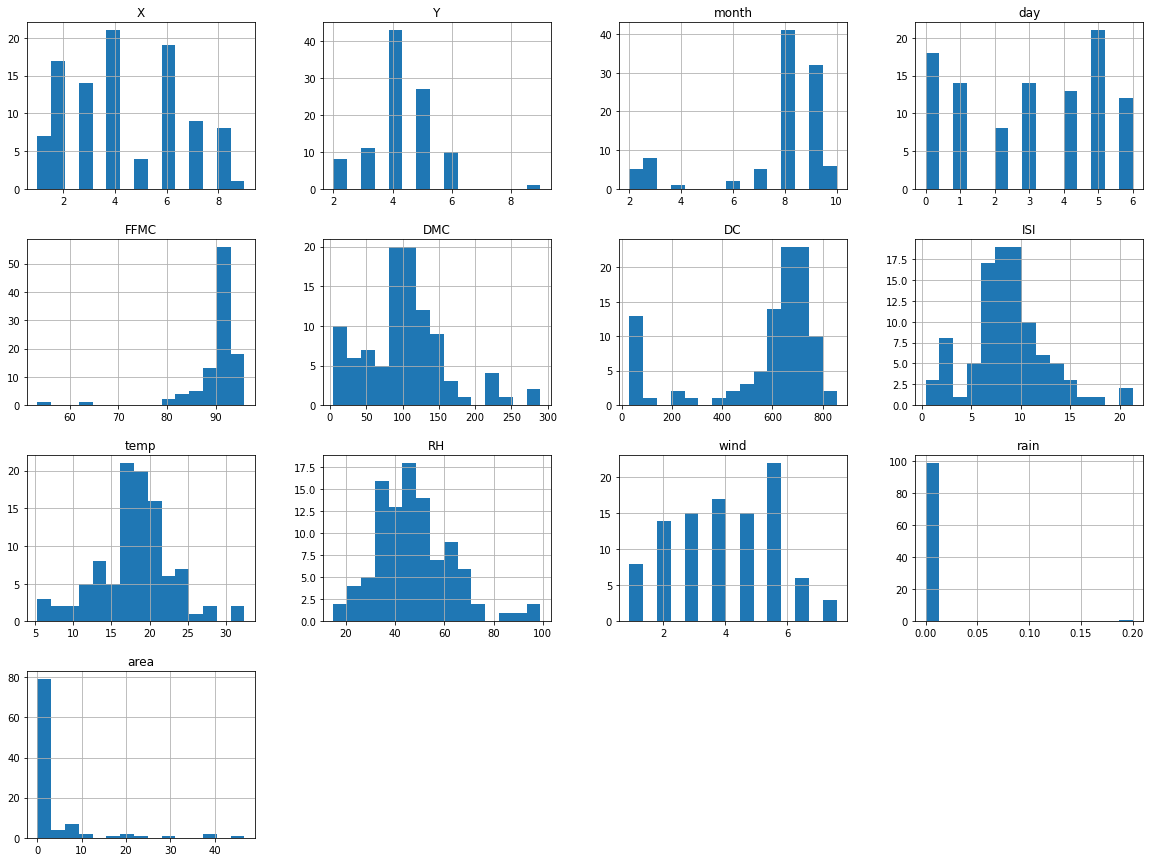

In [58]:
biased.hist(bins=15, figsize=(20,15))

In [ ]:
def test_train_gen(df, unseen, target, features, bias_dics):
    if bias_dics == []:
        return sk_test_train(df, target, features, test_ratio)
    else:
        total_rows = len(df)
        
        
    